In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, float64
from numba.experimental import jitclass
import quantecon as qe
from quantecon.distributions import BetaBinomial
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# The McCall Model

## Setup

<a id='index-0'></a>
An unemployed agent receives in each period a job offer at wage $ w_t $.

In this lecture, we adopt the following simple environment:

- The offer sequence $ \{w_t\}_{t \geq 0} $ is IID, with $ q(w) $ being the probability of observing wage $ w $ in finite set $ \mathbb{W} $.  
- The agent observes $ w_t $ at the start of $ t $.  
- The agent knows that $ \{w_t\} $ is IID with common distribution $ q $ and can use this when computing expectations.  



At time $ t $, our agent has two choices:

1. Accept the offer and work permanently at constant wage $ w_t $.  
1. Reject the offer, receive unemployment compensation $ c $, and reconsider next period.  


The agent is infinitely lived and aims to maximize the expected discounted
sum of earnings

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t 
$$

### The Value Function

In order to optimally trade-off current and future rewards, we need to think about two things:

1. the current payoffs we get from different choices  
1. the different states that those choices will lead to in next period  

Denote $ v^*(w) $ the value of the objective function when an agent in this situation makes optimal decisions now and at all future points in time.

This function $ v^* $ must satisfy the
recursion


<a id='equation-odu-pv'></a>
$$
v^*(w)
= \max \left\{
        \frac{w}{1 - \beta}, \, c + \beta
        \sum_{w' \in \mathbb{W}} v^*(w') q (w') \tag{1}
    \right\} 
$$

for every possible $ w $  in $ \mathbb{W} $.


- the first term inside the max operation is the lifetime payoff from accepting current offer, since  


$$
\frac{w}{1 - \beta} = w + \beta w + \beta^2 w + \cdots
$$

- the second term inside the max operation is the **continuation value**, which is the lifetime payoff from rejecting the current offer and then behaving optimally in all subsequent periods  




### The Optimal Policy


The **policy** is, in general, a map from states to actions.

Given *any* $ w $, we can read off the corresponding best choice (accept or
reject) by picking the max on the right-hand side of [(1)](#equation-odu-pv).

Thus, we have a map from $ \mathbb W $ to $ \{0, 1\} $, with 1 meaning accept and 0 meaning reject.

We can write the policy as follows

$$
\sigma(w) := \mathbf{1}
    \left\{
        \frac{w}{1 - \beta} \geq c + \beta \sum_{w' \in \mathbb W}
        v^*(w') q (w')
    \right\}
$$

Here $ \mathbf{1}\{ P \} = 1 $ if statement $ P $ is true and equals 0 otherwise.

We can also write this as

$$
\sigma(w) := \mathbf{1} \{ w \geq \bar w \}
$$

where


<a id='equation-reswage'></a>
$$
\bar w := (1 - \beta) \left\{ c + \beta \sum_{w'} v^*(w') q (w') \right\} \tag{2}
$$

Here $ \bar w $ (called the *reservation wage*) is a constant depending on
$ \beta, c $ and the wage distribution.

The agent should accept if and only if the current wage offer exceeds the reservation wage.


## Computation

We need to compute the value function at each possible state $ w \in \mathbb W $.

Let’s set

$$
\mathbb W := \{w_1, \ldots, w_n  \}
    \quad \text{and} \quad
    v^*(i) := v^*(w_i)
$$

The value function is then represented by the vector
$ v^* = (v^*(i))_{i=1}^n $.

In view of [(1)](#equation-odu-pv), this vector satisfies the nonlinear system of equations


<a id='equation-odu-pv2'></a>
$$
v^*(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v^*(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n \tag{3}
$$

### The Algorithm

To compute this vector, we use successive approximations:

Step 1: pick an arbitrary initial guess $ v \in \mathbb R^n $.

Step 2: compute a new vector $ v' \in \mathbb R^n $ via


<a id='equation-odu-pv2p'></a>
$$
v'(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n \tag{4}
$$

Step 3: calculate a measure of a discrepancy between $ v $ and $ v' $, such as $ \max_i |v(i)- v'(i)| $.

Step 4: if the deviation is larger than some fixed tolerance, set $ v = v' $ and go to step 2, else continue.

Step 5: return $ v $.

For a small tolerance, the returned function $ v $ is a close approximation to the value function $ v^* $.

### Implementation

Our default for $ q $, the distribution of the state process, will be
[Beta-binomial](https://en.wikipedia.org/wiki/Beta-binomial_distribution).

In [4]:
n, a, b = 50, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

In [5]:
w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

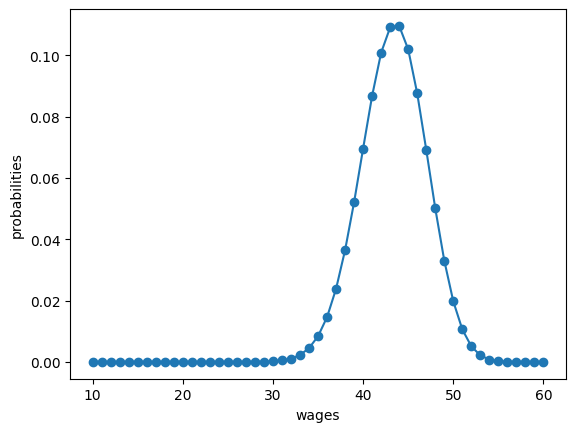

In [6]:
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

In [7]:
mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[::1]), # array of wage values, w[i] = wage at state i
    ('q', float64[::1])  # array of probabilities
]


@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w_default, q_default

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * (v @ q)

        return np.array([accept, reject])

Based on these defaults, let’s try plotting the first few approximate value functions
in the sequence $ \{ T^k v \} $.

We will start from guess $ v $ given by $ v(i) = w(i) / (1 - β) $, which is the value of accepting at every given wage.

Here’s a function to implement this:

In [8]:
def plot_value_function_seq(mcm, ax, num_plots=6):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for j in range(n):
            v_next[j] = np.max(mcm.state_action_values(j, v))
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

Now let’s create an instance of `McCallModel` and watch iterations  $ T^k v $ converge from below:

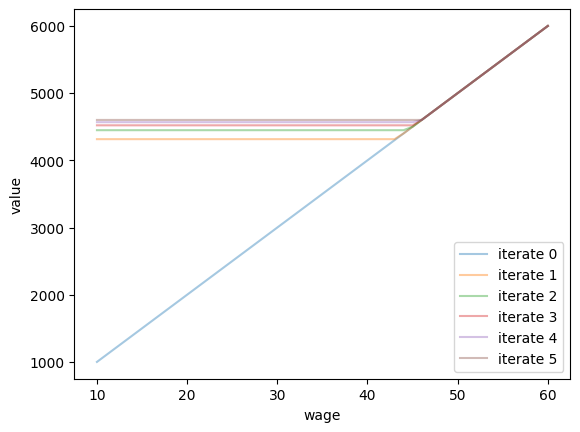

In [9]:
mcm = McCallModel()

fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

You can see that convergence is occurring: successive iterates are getting closer together.

Here’s a more serious iteration effort to compute the limit, which continues until measured deviation between successive iterates is below tol.

Once we obtain a good approximation to the limit, we will use it to calculate
the reservation wage.

We’ll be using JIT compilation via Numba to turbocharge our loops.

In [10]:
@jit
def compute_reservation_wage(mcm,
                             max_iter=500,
                             tol=1e-6):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute the value function == #

    n = len(w)
    v = w / (1 - β)          # initial guess
    v_next = np.empty_like(v)
    j = 0
    error = tol + 1
    while j < max_iter and error > tol:

        for j in range(n):
            v_next[j] = np.max(mcm.state_action_values(j, v))

        error = np.max(np.abs(v_next - v))
        j += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * (v @ q))

In [11]:
compute_reservation_wage(mcm)

47.31649971006253

### Comparative Statics

Now that we know how to compute the reservation wage, let’s see how it varies with
parameters.

In particular, let’s look at what happens when we change $ \beta $ and
$ c $.

In [12]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β)
        R[i, j] = compute_reservation_wage(mcm)

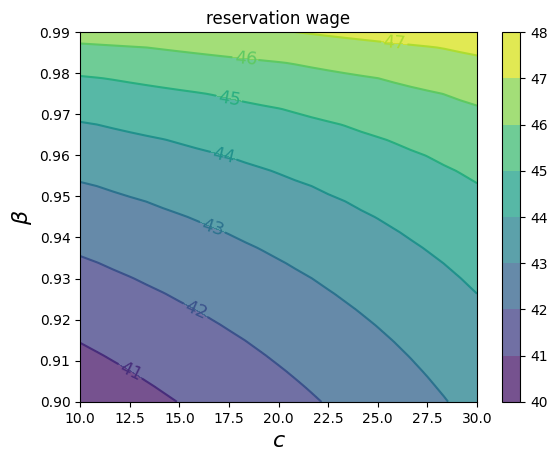

In [13]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

## Computation: alternative approach

The approach to dynamic programming just described is standard and
broadly applicable.

But for our McCall search model there’s also an easier way that  circumvents the
need to compute the value function.

Let $ h $ denote the continuation value:


<a id='equation-j1'></a>
$$
h
= c + \beta
    \sum_{s'} v^*(s') q (s')
\quad \tag{5}
$$

The Bellman equation can now be written as

$$
v^*(s')
= \max \left\{ \frac{w(s')}{1 - \beta}, \, h \right\}
$$

Substituting this last equation into [(42.6)](#equation-j1) gives


<a id='equation-j2'></a>
$$
h
= c + \beta
    \sum_{s' \in \mathbb S}
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s')
\quad \tag{6}
$$

This is a nonlinear equation that we can solve for $ h $.

As before, we will use successive approximations:

Step 1: pick an initial guess $ h $.

Step 2: compute the update $ h' $ via


<a id='equation-j3'></a>
$$
h'
= c + \beta
    \sum_{s' \in \mathbb S}
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s')
\quad \tag{7}
$$

Step 3: calculate the deviation $ |h - h'| $.

Step 4: if the deviation is larger than some fixed tolerance, set $ h = h' $ and go to step 2, else return $ h $.

One can again use the Banach contraction mapping theorem to show that this process always converges.

The big difference here, however, is that we’re iterating on a scalar $ h $, rather than an $ n $-vector, $ v(i), i = 1, \ldots, n $.

Here’s an implementation:

In [17]:
@jit
def compute_reservation_wage_two(mcm,
                                 max_iter=500,
                                 tol=1e-5):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute h == #

    h = (w @ q) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w / (1 - β), h)
        h_next = c + β * (s @ q)

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

# The Stochastic Optimal Growth Model

The model is a version of the standard one sector infinite horizon growth
model studied in

- [[Stokey *et al.*, 1989](https://python.quantecon.org/zreferences.html#id230)], chapter 2  
- [[Ljungqvist and Sargent, 2018](https://python.quantecon.org/zreferences.html#id194)], section 3.1  
- [EDTC](https://johnstachurski.net/edtc.html), chapter 1  
- [[Sundaram, 1996](https://python.quantecon.org/zreferences.html#id232)], chapter 12  


It is an extension of the simple [cake eating problem](https://python.quantecon.org/cake_eating_problem.html) we looked at earlier.

The extension involves

- nonlinear returns to saving, through a production function, and  
- stochastic returns, due to shocks to production.  


Despite these additions, the model is still relatively simple.

We regard it as a stepping stone to more sophisticated models.


## The Model


<a id='index-1'></a>
Consider an agent who owns an amount $ y_t \in \mathbb R_+ := [0, \infty) $ of a consumption good at time $ t $.

This output can either be consumed or invested.

When the good is invested, it is transformed one-for-one into capital.

The resulting capital stock, denoted here by $ k_{t+1} $, will then be used for production.

Production is stochastic, in that it also depends on a shock $ \xi_{t+1} $ realized at the end of the current period.

Next period output is

$$
y_{t+1} := f(k_{t+1}) \xi_{t+1}
$$

where $ f \colon \mathbb R_+ \to \mathbb R_+ $ is called the production function.

The resource constraint is


<a id='equation-outcsdp0'></a>
$$
k_{t+1} + c_t \leq y_t \tag{8}
$$

and all variables are required to be nonnegative.

### Assumptions and Comments

In what follows,

- The sequence $ \{\xi_t\} $ is assumed to be IID.  
- The common distribution of each $ \xi_t $ will be denoted by $ \phi $.  
- The production function $ f $ is assumed to be increasing and continuous.  
- Depreciation of capital is not made explicit but can be incorporated into the production function.  


While many other treatments of the stochastic growth model use $ k_t $ as the state variable, we will use $ y_t $.

This will allow us to treat a stochastic model while maintaining only one state variable.

We consider alternative states and timing specifications in some of our other lectures.

### Optimization

Taking $ y_0 $ as given, the agent wishes to maximize


<a id='equation-texs0-og2'></a>
$$
\mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right] \tag{9}
$$

subject to


<a id='equation-og-conse'></a>
$$
y_{t+1} = f(y_t - c_t) \xi_{t+1}
\quad \text{and} \quad
0 \leq c_t \leq y_t
\quad \text{for all } t \tag{10}
$$

where

- $ u $ is a bounded, continuous and strictly increasing utility function and  
- $ \beta \in (0, 1) $ is a discount factor.  


In [(10)](#equation-og-conse) we are assuming that the resource constraint [(8)](#equation-outcsdp0) holds with equality — which is reasonable because $ u $ is strictly increasing and no output will be wasted at the optimum.

In summary, the agent’s aim is to select a path $ c_0, c_1, c_2, \ldots $ for consumption that is

1. nonnegative,  
1. feasible in the sense of [(8)](#equation-outcsdp0),  
1. optimal, in the sense that it maximizes [(9)](#equation-texs0-og2) relative to all other feasible consumption sequences, and  
1. *adapted*, in the sense that the action $ c_t $ depends only on
  observable outcomes, not on future outcomes such as $ \xi_{t+1} $.  


In the present context

- $ y_t $ is called the *state* variable — it summarizes the “state of the world” at the start of each period.  
- $ c_t $ is called the *control* variable — a value chosen by the agent each period after observing the state.  

### The Bellman Equation


For this problem, the Bellman equation takes the form


<a id='equation-fpb30'></a>
$$
v(y) = \max_{0 \leq c \leq y}
    \left\{
        u(c) + \beta \int v(f(y - c) z) \phi(dz)
    \right\}
\qquad (y \in \mathbb R_+) \tag{11}
$$

This is a *functional equation in* $ v $.

### The Bellman Operator

The Bellman operator is denoted by $ T $ and defined by


<a id='equation-fcbell20-optgrowth'></a>
$$
Tv(y) := \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int v(f(y - c) z) \phi(dz)
\right\}
\qquad (y \in \mathbb R_+) \tag{11}
$$

In other words, $ T $ sends the function $ v $ into the new function
$ Tv $ defined by [(11)](#equation-fcbell20-optgrowth).

By construction, the set of solutions to the Bellman equation
[(10)](#equation-fpb30) *exactly coincides with* the set of fixed points of $ T $.

For example, if $ Tv = v $, then, for any $ y \geq 0 $,

$$
v(y)
= Tv(y)
= \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int v^*(f(y - c) z) \phi(dz)
\right\}
$$

which says precisely that $ v $ is a solution to the Bellman equation.

It follows that $ v^* $ is a fixed point of $ T $.

### Greedy Policies

The primary importance of the value function is that we can use it to compute optimal policies.

The details are as follows.

Given a continuous function $ v $ on $ \mathbb R_+ $, we say that
$ \sigma \in \Sigma $ is $ v $-**greedy** if $ \sigma(y) $ is a solution to


<a id='equation-defgp20'></a>
$$
\max_{0 \leq c \leq y}
    \left\{
    u(c) + \beta \int v(f(y - c) z) \phi(dz)
    \right\} \tag{12}
$$

for every $ y \in \mathbb R_+ $.

In other words, $ \sigma \in \Sigma $ is $ v $-greedy if it optimally
trades off current and future rewards when $ v $ is taken to be the value
function.

In our setting, we have the following key result

- A feasible consumption policy is optimal if and only if it is $ v^* $-greedy.  


Hence, once we have a good approximation to $ v^* $, we can compute the
(approximately) optimal policy by computing the corresponding greedy policy.


## Computation


The algorithm will be


<a id='fvi-alg'></a>
1. Begin with an array of values $ \{ v_1, \ldots, v_I \} $ representing
  the values of some initial function $ v $ on the grid points $ \{ y_1, \ldots, y_I \} $.  
1. Build a function $ \hat v $ on the state space $ \mathbb R_+ $ by
  linear interpolation, based on these data points.  
1. Obtain and record the value $ T \hat v(y_i) $ on each grid point
  $ y_i $ by repeatedly solving [(57.11)](#equation-fcbell20-optgrowth).  
1. Unless some stopping condition is satisfied, set
  $ \{ v_1, \ldots, v_I \} = \{ T \hat v(y_1), \ldots, T \hat v(y_I) \} $ and go to step 2.  

### Scalar Maximization

To maximize the right hand side of the Bellman equation [(10)](#equation-fpb30), we are going to use
the `minimize_scalar` routine from SciPy.

Since we are maximizing rather than minimizing, we will use the fact that the
maximizer of $ g $ on the interval $ [a, b] $ is the minimizer of
$ -g $ on the same interval.

To this end, and to keep the interface tidy, we will wrap `minimize_scalar`
in an outer function as follows:

In [20]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

### Optimal Growth Model

We will assume for now that $ \phi $ is the distribution of $ \xi := \exp(\mu + s \zeta) $ where

- $ \zeta $ is standard normal,  
- $ \mu $ is a shock location parameter and  
- $ s $ is a shock scale parameter.  


We will store this and other primitives of the optimal growth model in a class.

The class, defined below, combines both parameters and a method that realizes the
right hand side of the Bellman equation [(57.9)](#equation-fpb30).

In [21]:
class OptimalGrowthModel:

    def __init__(self,
                 u,            # utility function
                 f,            # production function
                 β=0.96,       # discount factor
                 μ=0,          # shock location parameter
                 s=0.1,        # shock scale parameter
                 grid_max=4,
                 grid_size=120,
                 shock_size=250,
                 seed=1234):

        self.u, self.f, self.β, self.μ, self.s = u, f, β, μ, s

        # Set up grid
        self.grid = np.linspace(1e-4, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))

    def state_action_value(self, c, y, v_array):
        """
        Right hand side of the Bellman equation.
        """

        u, f, β, shocks = self.u, self.f, self.β, self.shocks

        v = interp1d(self.grid, v_array)

        return u(c) + β * np.mean(v(f(y - c) * shocks))

In the second last line we are using linear interpolation.

In the last line, the expectation in [(57.11)](#equation-fcbell20-optgrowth) is
computed via [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_integration), using the approximation

$$
\int v(f(y - c) z) \phi(dz) \approx \frac{1}{n} \sum_{i=1}^n v(f(y - c) \xi_i)
$$

where $ \{\xi_i\}_{i=1}^n $ are IID draws from $ \phi $.

Monte Carlo is not always the most efficient way to compute integrals numerically
but it does have some theoretical advantages in the present setting.

(For example, it preserves the contraction mapping property of the Bellman operator — see, e.g., [[Pál and Stachurski, 2013](https://python.quantecon.org/zreferences.html#id139)].)

In [22]:
def T(v, og):
    """
    The Bellman operator.  Updates the guess of the value function
    and also computes a v-greedy policy.

      * og is an instance of OptimalGrowthModel
      * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)

    for i in range(len(grid)):
        y = grid[i]

        # Maximize RHS of Bellman equation at state y
        c_star, v_max = maximize(og.state_action_value, 1e-10, y, (y, v))
        v_new[i] = v_max
        v_greedy[i] = c_star

    return v_greedy, v_new

### An Example

Let’s suppose now that

$$
f(k) = k^{\alpha}
\quad \text{and} \quad
u(c) = \ln c
$$

For this particular problem, an exact analytical solution is available (see [[Ljungqvist and Sargent, 2018](https://python.quantecon.org/zreferences.html#id194)], section 3.1.2), with


<a id='equation-dpi-tv'></a>
$$
v^*(y) =
\frac{\ln (1 - \alpha \beta) }{ 1 - \beta} +
\frac{(\mu + \alpha \ln (\alpha \beta))}{1 - \alpha}
 \left[
     \frac{1}{1- \beta} - \frac{1}{1 - \alpha \beta}
 \right] +
 \frac{1}{1 - \alpha \beta} \ln y \tag{13}
$$

and optimal consumption policy

$$
\sigma^*(y) = (1 - \alpha \beta ) y
$$

It is valuable to have these closed-form solutions because it lets us check
whether our code works for this particular case.

In Python, the functions above can be expressed as:

In [24]:
def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y

In [25]:
α = 0.4
def fcd(k):
    return k**α

og = OptimalGrowthModel(u=np.log, f=fcd)

Now let’s see what happens when we apply our Bellman operator to the exact
solution $ v^* $ in this case.

In theory, since $ v^* $ is a fixed point, the resulting function should again be $ v^* $.

In practice, we expect some small numerical error.

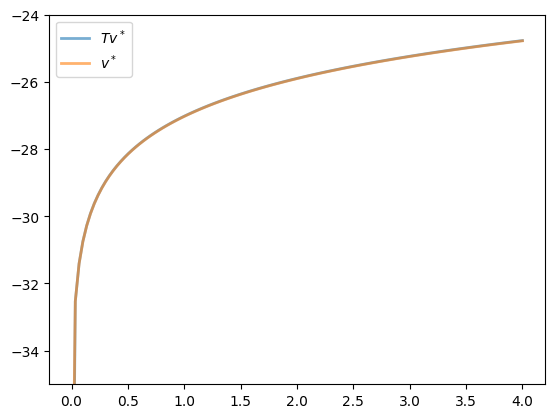

In [26]:
grid = og.grid

v_init = v_star(grid, α, og.β, og.μ)    # Start at the solution
v_greedy, v = T(v_init, og)             # Apply T once

fig, ax = plt.subplots()
ax.set_ylim(-35, -24)
ax.plot(grid, v, lw=2, alpha=0.6, label='$Tv^*$')
ax.plot(grid, v_init, lw=2, alpha=0.6, label='$v^*$')
ax.legend()
plt.show()

The two functions are essentially indistinguishable, so we are off to a good start.

Now let’s have a look at iterating with the Bellman operator, starting
from an arbitrary initial condition.

The initial condition we’ll start with is, somewhat arbitrarily, $ v(y) = 5 \ln (y) $.

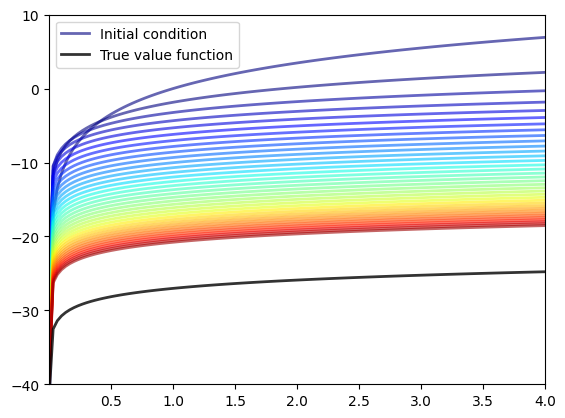

In [27]:
v = 5 * np.log(grid)  # An initial condition
n = 35

fig, ax = plt.subplots()

ax.plot(grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial condition')

for i in range(n):
    v_greedy, v = T(v, og)  # Apply the Bellman operator
    ax.plot(grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.plot(grid, v_star(grid, α, og.β, og.μ), 'k-', lw=2,
        alpha=0.8, label='True value function')

ax.legend()
ax.set(ylim=(-40, 10), xlim=(np.min(grid), np.max(grid)))
plt.show()

The figure shows

1. the first 36 functions generated by the fitted value function iteration algorithm, with hotter colors given to higher iterates  
1. the true value function $ v^* $ drawn in black  


The sequence of iterates converges towards $ v^* $.

We are clearly getting closer.

### Iterating to Convergence

We can write a function that iterates until the difference is below a particular
tolerance level.

In [28]:
def solve_model(og,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):
    """
    Solve model by iterating with the Bellman operator.

    """

    # Set up loop
    v = og.u(og.grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_greedy, v_new = T(v, og)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_greedy, v_new

Let’s use this function to compute an approximate solution at the defaults.

In [30]:
v_greedy, v_solution = solve_model(og)

Error at iteration 25 is 0.40975776844489786.
Error at iteration 50 is 0.14767535408237364.
Error at iteration 75 is 0.05322171277214238.
Error at iteration 100 is 0.019180930548646558.
Error at iteration 125 is 0.006912744396032622.
Error at iteration 150 is 0.0024913303848101975.
Error at iteration 175 is 0.0008978672913002583.
Error at iteration 200 is 0.0003235884239778386.
Error at iteration 225 is 0.00011662020561686859.

Converged in 229 iterations.


Now we check our result by plotting it against the true value:

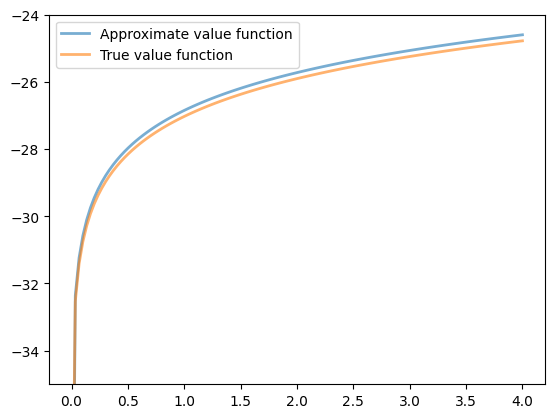

In [31]:
fig, ax = plt.subplots()

ax.plot(grid, v_solution, lw=2, alpha=0.6,
        label='Approximate value function')

ax.plot(grid, v_star(grid, α, og.β, og.μ), lw=2,
        alpha=0.6, label='True value function')

ax.legend()
ax.set_ylim(-35, -24)
plt.show()

### The Policy Function


<a id='index-7'></a>
The policy `v_greedy` computed above corresponds to an approximate optimal policy.

The next figure compares it to the exact solution, which, as mentioned
above, is $ \sigma(y) = (1 - \alpha \beta) y $

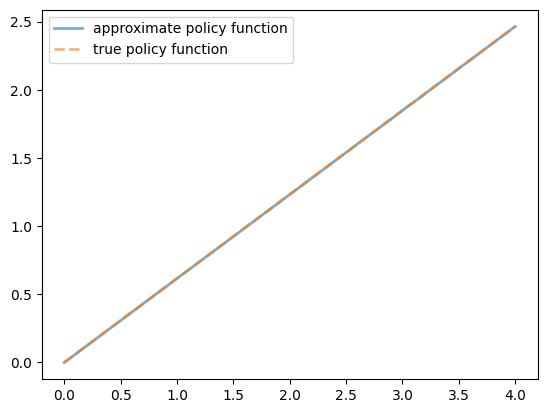

In [32]:
fig, ax = plt.subplots()

ax.plot(grid, v_greedy, lw=2,
        alpha=0.6, label='approximate policy function')

ax.plot(grid, σ_star(grid, α, og.β), '--',
        lw=2, alpha=0.6, label='true policy function')

ax.legend()
plt.show()